# Movie Recommender System

### Recommender Systems are used almost everywhere these days. They are used in e-commerce sites to suggest related products. They are used in Youtube,Netflix,Amazon Prime Videos,Facebook etc,. These systems aim to suggest most accurate and related items based on user's interest and past browsing history.

### In this particluar notebook we are going to look at various types of recommender systems and bulid these recommender systems to suggest related movies based on the user's input movie name. This system takes into account various factors like Cast of the movie, Director of the movie, Genre of the movie, Overview of the movie,Keywords used in the movie  to suggest most related movies.

In [726]:
import pandas as pd                   # for data analysis
import numpy as np                    # for vector manipulation
import matplotlib.pyplot as mlt       # for data visualization
import seaborn as sns                 # for data visualization
import ast                            # to convert string to list
from sklearn.metrics.pairwise import cosine_similarity        # to find similarity between elements
from sklearn.feature_extraction.text import CountVectorizer   # to find similarity between elements
data1=pd.read_csv('Downloads/Extra/ds/movies/tmdb_credits.csv')
data2=pd.read_csv('Downloads/Extra/ds/movies/tmdb_movies.csv')

Let's join the two dataset on the 'id' column of 'data2' and 'movie_id' column of data1.

In [695]:
data = pd.merge(data2,data1,left_on='id',right_on='movie_id')

Since both the dataframes had common column 'title' two columns got created. So, now let's delte one of it and rename the other.

In [696]:
del data['title_y']
data=data.rename(columns={'title_x':'title'})

### Demographic Recommender System

We need to calculate following fields before we proceed further:
* Metric to score movies
* Score for all every movie
* Sort the scores of all movies and recommend best rated movies.

We cannot use the average ratings of movies as the score, because it won't be fair enough since a movie with 9.2 average rating and only 2 votes cannot be considered better than the movie with 8.2 as as average rating and has 1000 votes. So, we will use weighted rating (WR), which can be calculated using the below formula:

Weighted Rating (WR) = (v*R/(v+m)) + (m*C/(v+m))

where,

m = Minimum cutoff votes required

v = Total number of votes recieved by the movie.

C = Mean votes across all movies.

R = Average rating of the movie.    

In [697]:
C= data['vote_average'].mean()
C

6.092171559442011

As seen above, the average rating for all the movies is approx 6 out of 10. Now we need to find minimum cutoff votes (m). I will be using cutoff as 90th percentile. In simple words, for a particular movie to be listed for my further analysis, it should have higher votes than atleast 90% of  all the movies in the list.

In [698]:
m= data['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can select only those movies that qualify this score for our analysis.

In [699]:
qualified_movies = data.copy().loc[data['vote_count'] >= m]
qualified_movies.shape

(481, 23)

In [700]:
def weighted_movie_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [701]:
# Defining a new feature called 'score' and calculating its value with weighted_movie_rating function.
qualified_movies['score'] = qualified_movies.apply(weighted_movie_rating, axis=1)

In [702]:
#Sorting movies based on the score
qualified_movies = qualified_movies.sort_values('score', ascending=False)

#Printing the top 10 movies
qualified_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


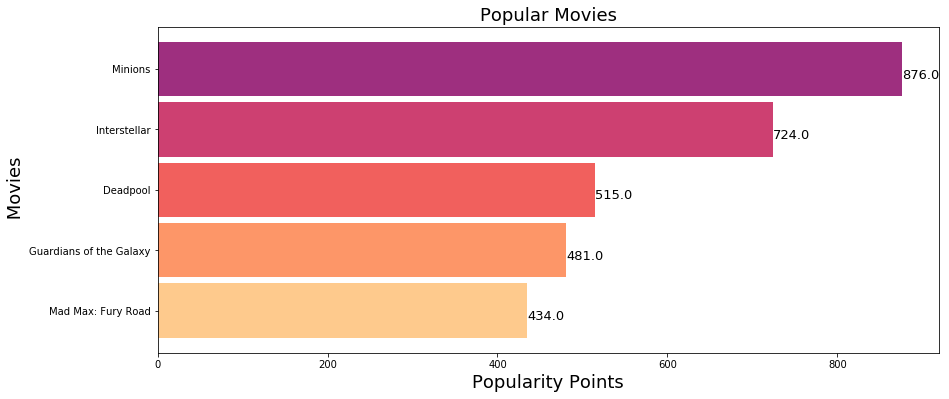

In [703]:
popular = data.sort_values('popularity',ascending=False).head()
popular = popular.set_index('title')
mlt.subplots(figsize=(14,6))
ax = popular['popularity'].sort_values().head().plot.barh(width =0.9, align='center',color=sns.color_palette('magma_r',8))
ax.set_xlabel("Popularity Points", fontsize=18)
ax.set_ylabel(" Movies", fontsize=18)
ax.set_title("Popular Movies",fontsize=18,color='black')
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.4, i.get_y()+.3,str(round(i.get_width())), fontsize=13,color='black')
plt.show()

This demographic recommender gives a common recommended movies to all the users. It is insensitive to the interests of any individual user.So, we will be looking into  more user specific recommender system : Content Based Recommender System.

### Content Based Recommender System 

In this System, similarity with the movies is found using the content of the movie like actors, director,summary etc,.

In [704]:
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [705]:
# Movie recommednation function
def get_movie_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df2['title'].iloc[movie_indices]

In [706]:
# Reverese mapping
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

In [707]:
# To get director's name
def get_director(d):
    for i in d:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [708]:
# To get top three entries.
def get_list(top):
    if isinstance(top, list):
        names = [i['name'] for i in top]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [709]:
# To convert strings to lists
data['crew'] = data.crew.apply(lambda s: list(ast.literal_eval(s)))
data['cast'] = data.cast.apply(lambda s: list(ast.literal_eval(s)))
data['keywords'] = data.keywords.apply(lambda s: list(ast.literal_eval(s)))
data['genres'] = data.genres.apply(lambda s: list(ast.literal_eval(s)))

In [710]:
#Extracting director's name for each movie.
data['director'] = data['crew'].apply(get_director)

In [711]:
#Extracing reuired features.
features = ['cast', 'keywords', 'genres']
for f in features:
    data[f] = data[f].apply(get_list)

In [712]:
data[['title','genres','director', 'cast', 'keywords']].head()


,title,genres,director,cast,keywords
0,Avatar,"[Action, Adventure, Fantasy]",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[culture clash, future, space war]"
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[ocean, drug abuse, exotic island]"
2,Spectre,"[Action, Adventure, Crime]",Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[spy, based on novel, secret agent]"
3,The Dark Knight Rises,"[Action, Crime, Drama]",Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]","[dc comics, crime fighter, terrorist]"
4,John Carter,"[Action, Adventure, Science Fiction]",Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]","[based on novel, mars, medallion]"


In [713]:
def data_cleaning(c):
    if isinstance(c, list):
        return [str.lower(i.replace(" ", "")) for i in c]
    else:
        if isinstance(c, str):
            return str.lower(c.replace(" ", ""))
        else:
            return ''

In [714]:
features = ['cast', 'keywords', 'director', 'genres']

for f in features:
    data[f] = data[f].apply(data_cleaning)

In [715]:
def create_movie_soup(m):
    return ' '.join(m['keywords']) + ' ' + ' '.join(m['cast']) + ' ' + m['director'] + ' ' + ' '.join(m['genres'])
data['movie_soup'] = data.apply(create_movie_soup, axis=1)

In [716]:
# to find cosine similarity
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['movie_soup'])
cosine_similarity = cosine_similarity(count_matrix, count_matrix)
data = data.reset_index()
indices = pd.Series(data.index, index=data['title'])

## Sample Results

### Sample Output 1 

In [717]:
output = get_movie_recommendations('Pirates of the Caribbean: On Stranger Tides', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,G-Force
1,Pirates of the Caribbean: At World's End
2,Pirates of the Caribbean: Dead Man's Chest
3,Pirates of the Caribbean: The Curse of the Black Pearl
4,The Mummy: Tomb of the Dragon Emperor
5,The Monkey King 2
6,The Sorcerer's Apprentice
7,Sahara
8,Fantastic 4: Rise of the Silver Surfer
9,Hercules


### Sample Output 2 

In [718]:
output = get_movie_recommendations('Avengers: Age of Ultron', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,The Avengers
1,Iron Man 2
2,Captain America: Civil War
3,Thor: The Dark World
4,Ant-Man
5,X2
6,X-Men
7,Iron Man 3
8,X-Men: The Last Stand
9,Transformers: Age of Extinction


### Sample Output 3 

In [719]:
output = get_movie_recommendations('Tangled', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,Pinocchio
1,Thunder and the House of Magic
2,Running Forever
3,Toy Story 3
4,The Smurfs
5,Hotel Transylvania
6,Alvin and the Chipmunks: The Squeakquel
7,Aladdin
8,Valiant
9,Atlantis: The Lost Empire


### Sample Output 4 

In [720]:
output = get_movie_recommendations('The Hobbit: The Battle of the Five Armies', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,The Hobbit: An Unexpected Journey
1,The Hobbit: The Desolation of Smaug
2,The Lord of the Rings: The Fellowship of the Ring
3,The Lord of the Rings: The Return of the King
4,The Lord of the Rings: The Two Towers
5,Warcraft
6,The Borrowers
7,The Mummy: Tomb of the Dragon Emperor
8,The Monkey King 2
9,The Sorcerer's Apprentice


### Sample Output 5  

In [721]:
output = get_movie_recommendations('Titanic', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,Revolutionary Road
1,Me You and Five Bucks
2,The Great Gatsby
3,All the King's Men
4,Angel Eyes
5,The Reader
6,Sense and Sensibility
7,Romeo + Juliet
8,Little Children
9,What's Eating Gilbert Grape


### Sample Output 6

In [722]:
output = get_movie_recommendations('Kung Fu Panda', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,Kung Fu Panda 3
1,Kung Fu Panda 2
2,The Tale of Despereaux
3,Valiant
4,Atlantis: The Lost Empire
5,Legend of the Guardians: The Owls of Ga'Hoole
6,Epic
7,Walking With Dinosaurs
8,Jungle Shuffle
9,Running Forever


### Sample Output 8 

In [723]:
output = get_movie_recommendations('Skyfall', cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,Spectre
1,Quantum of Solace
2,Mission: Impossible - Rogue Nation
3,Tomorrow Never Dies
4,Casino Royale
5,Mission: Impossible
6,The Hunting Party
7,Never Say Never Again
8,Diamonds Are Forever
9,Killer Elite


### Sample Output 9 

In [724]:
output = get_movie_recommendations("Harry Potter and the Philosopher's Stone", cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,Harry Potter and the Chamber of Secrets
1,Harry Potter and the Half-Blood Prince
2,Harry Potter and the Order of the Phoenix
3,Harry Potter and the Goblet of Fire
4,Harry Potter and the Prisoner of Azkaban
5,Oz: The Great and Powerful
6,"The Chronicles of Narnia: The Lion, the Witch and the Wardrobe"
7,The Chronicles of Narnia: The Voyage of the Dawn Treader
8,Pan
9,Spirited Away


### Sample Output 10 

In [725]:
output = get_movie_recommendations("Accidental Love", cosine_similarity).reset_index(drop=True).reset_index().rename(columns={'title':'Recommended Movies'})
del output['index']
output

,Recommended Movies
0,I Heart Huckabees
1,Easy Virtue
2,The Ugly Truth
3,Silver Linings Playbook
4,Flirting with Disaster
5,Me You and Five Bucks
6,Never Again
7,You've Got Mail
8,Two Weeks Notice
9,Valentine's Day
